# Group
- Sofia MARCHIORETTO
- Alain Marcel DIKANDE SIMO
- Yhony MAMANI ARCE
- Juan Diego VIZCAINO SORIANO
- Juan Sebastian VELEZ ROJAS 

### Introduction

Data represents the percentage of mRNA relative to each gene $i$ measured in various enviromental conditions, at each of which corresponds a constant growth rate $\lambda$ (we assume to be in equilibrium exponential growth). We assume that all this mRNA will then be equally translated into protein and therefore that we can treat the data as the percentages of the proteome that is relative to protein $i$. According to Scott et al., 2010 we can divide the proteome in classes: ribosome-affiliated "class R" with percentage $\phi_R$, "class Q" of regulated proteins with percentage $\phi_Q$ indipendent of the growth rate and "class P" of constitutively expressed protein with percentage $\phi_P$ dependent on the growth rate. We can then split the P class into classes C and A, with percentages $\phi_C$ and $\phi_A$, accounting respectively for proteins affiliated with catabolic processes and anabolic processes. The model then is as follows:

$$ \lambda(E) = \kappa_c(E) \phi_C(E) = \kappa_A(E) \phi_A(E) = \kappa_t(E) \left( \phi_R(E) - \phi_0 \right) $$
$$ \phi_A(E) + \phi_C(E) + \phi_R(E) = 1-\phi_Q = \phi_{max} $$

where E represents the environmental conditions.
Given that the percentages $\phi$ are the total amount of proteins for each class we decide to group gene $i \in {1,\dots,N}$ according to their functionalities $\alpha_i \in \{ copy here the unique letters for functionality \}$ to obtain the percentage of proteome of a given functionality $\alpha$:

$$ \phi_{\alpha} = \sum_{i=1} ^N \phi_i \delta_{\alpha_i,\alpha} $$

We aim at identify one or multiple functionalities that belong to groups Q, R, A, C by analyzing their dependency with respect to $\lambda$.

### Import the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
sns.set(style="whitegrid")
sns.set_theme()

### Import the Data

- `df`: Contains the gene abundance vs. the condition.
- `df1`: Contains the condition vs. growth rate and so on.
- `df2`: Contains the gene abundance vs. functionality and so on.

In [2]:
df = pd.read_csv('transcriptomics_fractions.csv')
df1 = pd.read_csv('samples_transcriptomics.csv', index_col='Unnamed: 0').set_index('Sample.ID')
df2 = pd.read_csv('Ecoli_gene_functional_annotations.csv', encoding = 'cp1252', index_col='Unnamed: 0')

Deleting empty Data in DataFrame `df2`

In [3]:
df_renamed = df.rename(columns={'Unnamed: 0': 'gene'})
df_T = df_renamed.set_index('gene')
df2_sorted = df2.dropna(subset=['gene']).sort_values(by='gene', ascending=True).reset_index(drop=True)
df2_s = df2_sorted.set_index('gene')

In [4]:
df_join = pd.merge(df2_s, df_T, left_index=True, right_index=True)

Separating by group **Alim**, **Clim** and **Rlim**

In [5]:
Alim = df_join.loc[:,:'a4_1'].sort_values(by='top_cog_functional_cat', ascending=True)
Clim = df_join.drop(df_join.columns[list(range(7,14)) + list(range(24, 35))], axis=1).sort_values(by='top_cog_functional_cat', ascending=True)
Rlim = df_join.drop(df_join.columns[7:24], axis=1).sort_values(by='top_cog_functional_cat', ascending=True)

Creating a function `ffunctionality(group, functionality, a ,b)` where the parameters passed to it are the `group` (**Alim**, **Clim** or **Rlim**), the `functionality` and the values by which it will be separated, where it is commented in the function for each group what values `a` and `b` take. This function basically separates the functionalities (`A`, `C`, etc.) for each group.

In [6]:
def ffunctionality(group, functionality, a ,b):
    """a, b =  0, 7 for Alim
    a, b =  7, 17 for Clim
    a, b =  17, 28 for Rlim """
    func = group['top_cog_functional_cat'].tolist()
    for raw in enumerate(func):
        group_func = group[group['top_cog_functional_cat']==str(functionality)]
        group_f= group_func.iloc[:,7:].T
        #group_f['Growth.rate']= list(df1['Growth.rate..1.h.'][a:b])
        group_f['Gene.sum'] = group_f.sum(axis=1)
        group_ff = group_f['Gene.sum']
    return pd.merge(df1[a:b][:], group_ff, left_index=True, right_index=True)

This function `Tcog_func(G_name, group, a, b)` separates the `functionality` of each `group` and stores them in a dictionary. Where the key is the group and the functionality (e.g. `Alim_A`, etc), and the value is the DataFrames with their respective characteristics.

In [7]:
def Tcog_func(G_name, group, a, b):
    func = list(dict.fromkeys(Alim['top_cog_functional_cat'].tolist()))
    df_dict = {}
    for i in func:
        df_result = ffunctionality(group, i, a, b)
        df_dict[f"{G_name}_{i}"] = df_result
        #print(f"{G_name}_{i}")
    return df_dict

Saving the dictionary for each `group`

In [8]:
ATcog_func_by_functionality = Tcog_func("Alim", Alim, 0, 7)

In [9]:
CTcog_func_by_functionality = Tcog_func("Clim", Clim, 7, 17)

In [10]:
RTcog_func_by_functionality = Tcog_func("Rlim", Rlim, 17, 28)

In [11]:
def generar_colores_hsv(n, saturacion=0.7, brillo=0.9):
    paso = 1.7 / n
    lista_colores = []
    for i in range(n):
        matiz = i * paso
        rgb = mcolors.hsv_to_rgb((matiz, saturacion, brillo))
        lista_colores.append(mcolors.to_hex(rgb))
    return lista_colores

This function `plot_group_join(group_cog)`, given the `group`, creates a plot with the `functionalities`, that is, on the x axis there is the `Growth Rate` and on the y axis there is the `Abundance`. It also fit them.

In [12]:
def plot_group_join(group_cog):
    key_dic = list(group_cog.keys()) 
    
    palette = generar_colores_hsv(len(key_dic))

    fig, ax = plt.subplots(figsize=(11, 5))

    for idx, key in enumerate(key_dic):
        color = palette[idx] 

        sns.regplot(
            x=group_cog[key]['Growth.rate..1.h.'], 
            y=group_cog[key]['Gene.sum'], 
            ax=ax, 
            marker='o', 
            label=str(key[-1][0]), 
            scatter_kws={'s': 20, 'color': color},  
            line_kws={'color': color, 'linewidth': 1}, 
            ci=None  
        )

    ax.set_xlabel('Growth Rate', fontsize=13)
    ax.set_ylabel('Abundance', fontsize=13)
    ax.set_title(str(key_dic[0]).split('_')[0], fontsize=13)
    ax.legend(fontsize=6)
    plt.tight_layout()
    
    plt.show()

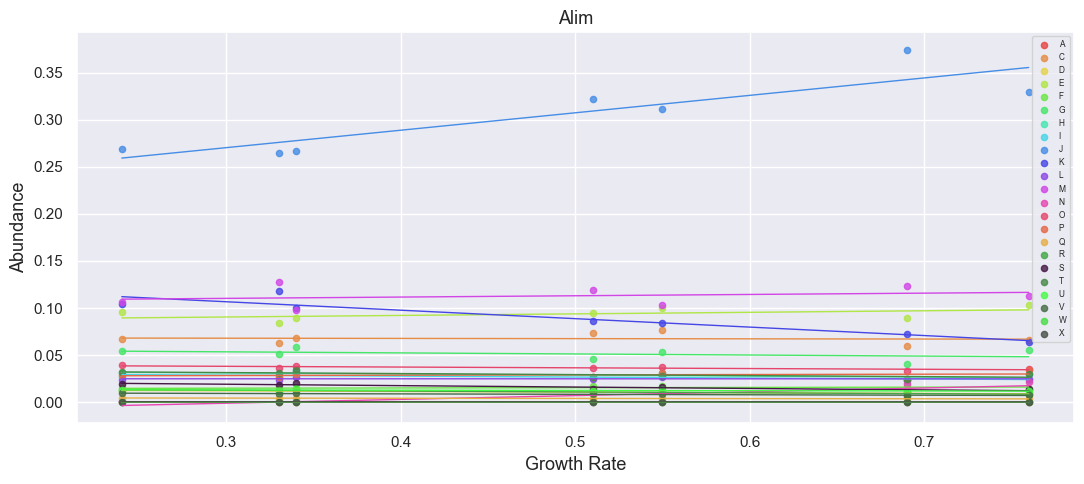

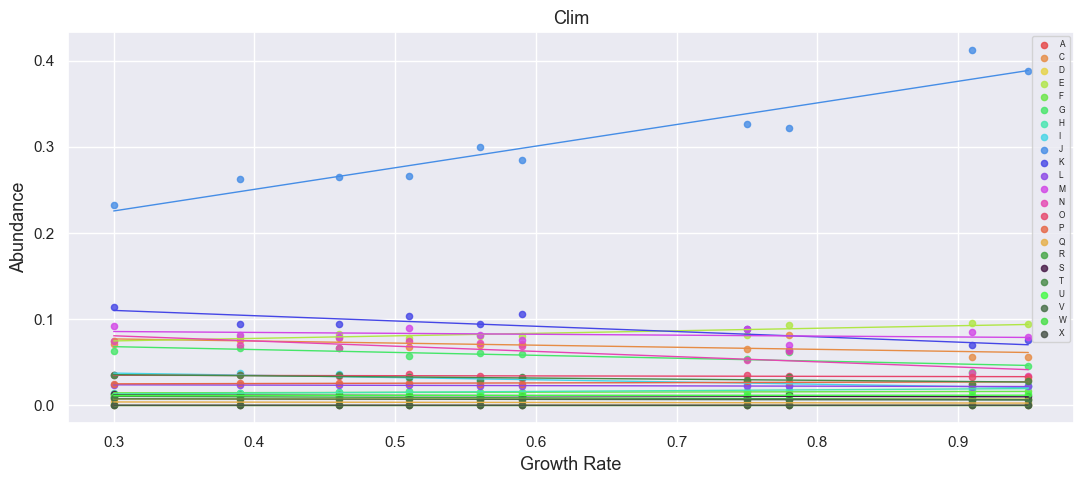

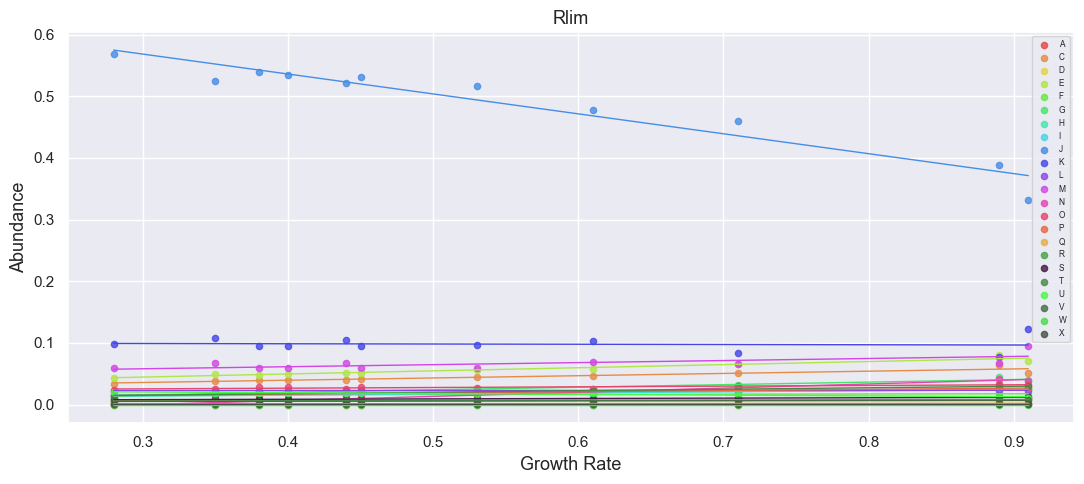

In [13]:
Alim_plot_fit = plot_group_join(ATcog_func_by_functionality)
Clim_plot_fit = plot_group_join(CTcog_func_by_functionality)
Rlim_plot_fit = plot_group_join(RTcog_func_by_functionality)

This function `plot_join_sep_by_func()` plots the three groups for each functionality and it also fit.

In [14]:
import math
def plot_join_sep_by_func():
    groups_data = {
        'Alim': ATcog_func_by_functionality,
        'Clim': CTcog_func_by_functionality,
        'Rlim': RTcog_func_by_functionality
    }
    
    base_functionalities = sorted(list(df2['top_cog_functional_cat'].unique())) 
    
    palette = sns.color_palette("Set1", len(groups_data))
    
    cols_per_row = 3  
    total_plots = len(base_functionalities)
    rows = math.ceil(total_plots / cols_per_row)  

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))

    if rows == 1:
        axes = np.array([axes])  

    for idx, base_functionality in enumerate(base_functionalities):
        row = idx // cols_per_row
        col = idx % cols_per_row
        ax = axes[row, col]

        for j, (group, data) in enumerate(groups_data.items()):
            functionality_key = f"{group}_{base_functionality}"
            
            if functionality_key in data:
                color = palette[j]
                
                sns.regplot(
                    x=data[functionality_key]['Growth.rate..1.h.'], 
                    y=data[functionality_key]['Gene.sum'], 
                    ax=ax, 
                    marker='o', 
                    label=group, 
                    scatter_kws={'s': 50, 'color': color},  
                    line_kws={'color': color},  
                    ci=None  
                )
        
        ax.set_title(f'Functionality {base_functionality}', fontsize=14)
        ax.set_xlabel('Growth Rate', fontsize=12)
        ax.set_ylabel('Concentration', fontsize=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.legend(fontsize=10)

    for idx in range(total_plots, rows * cols_per_row):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.show()

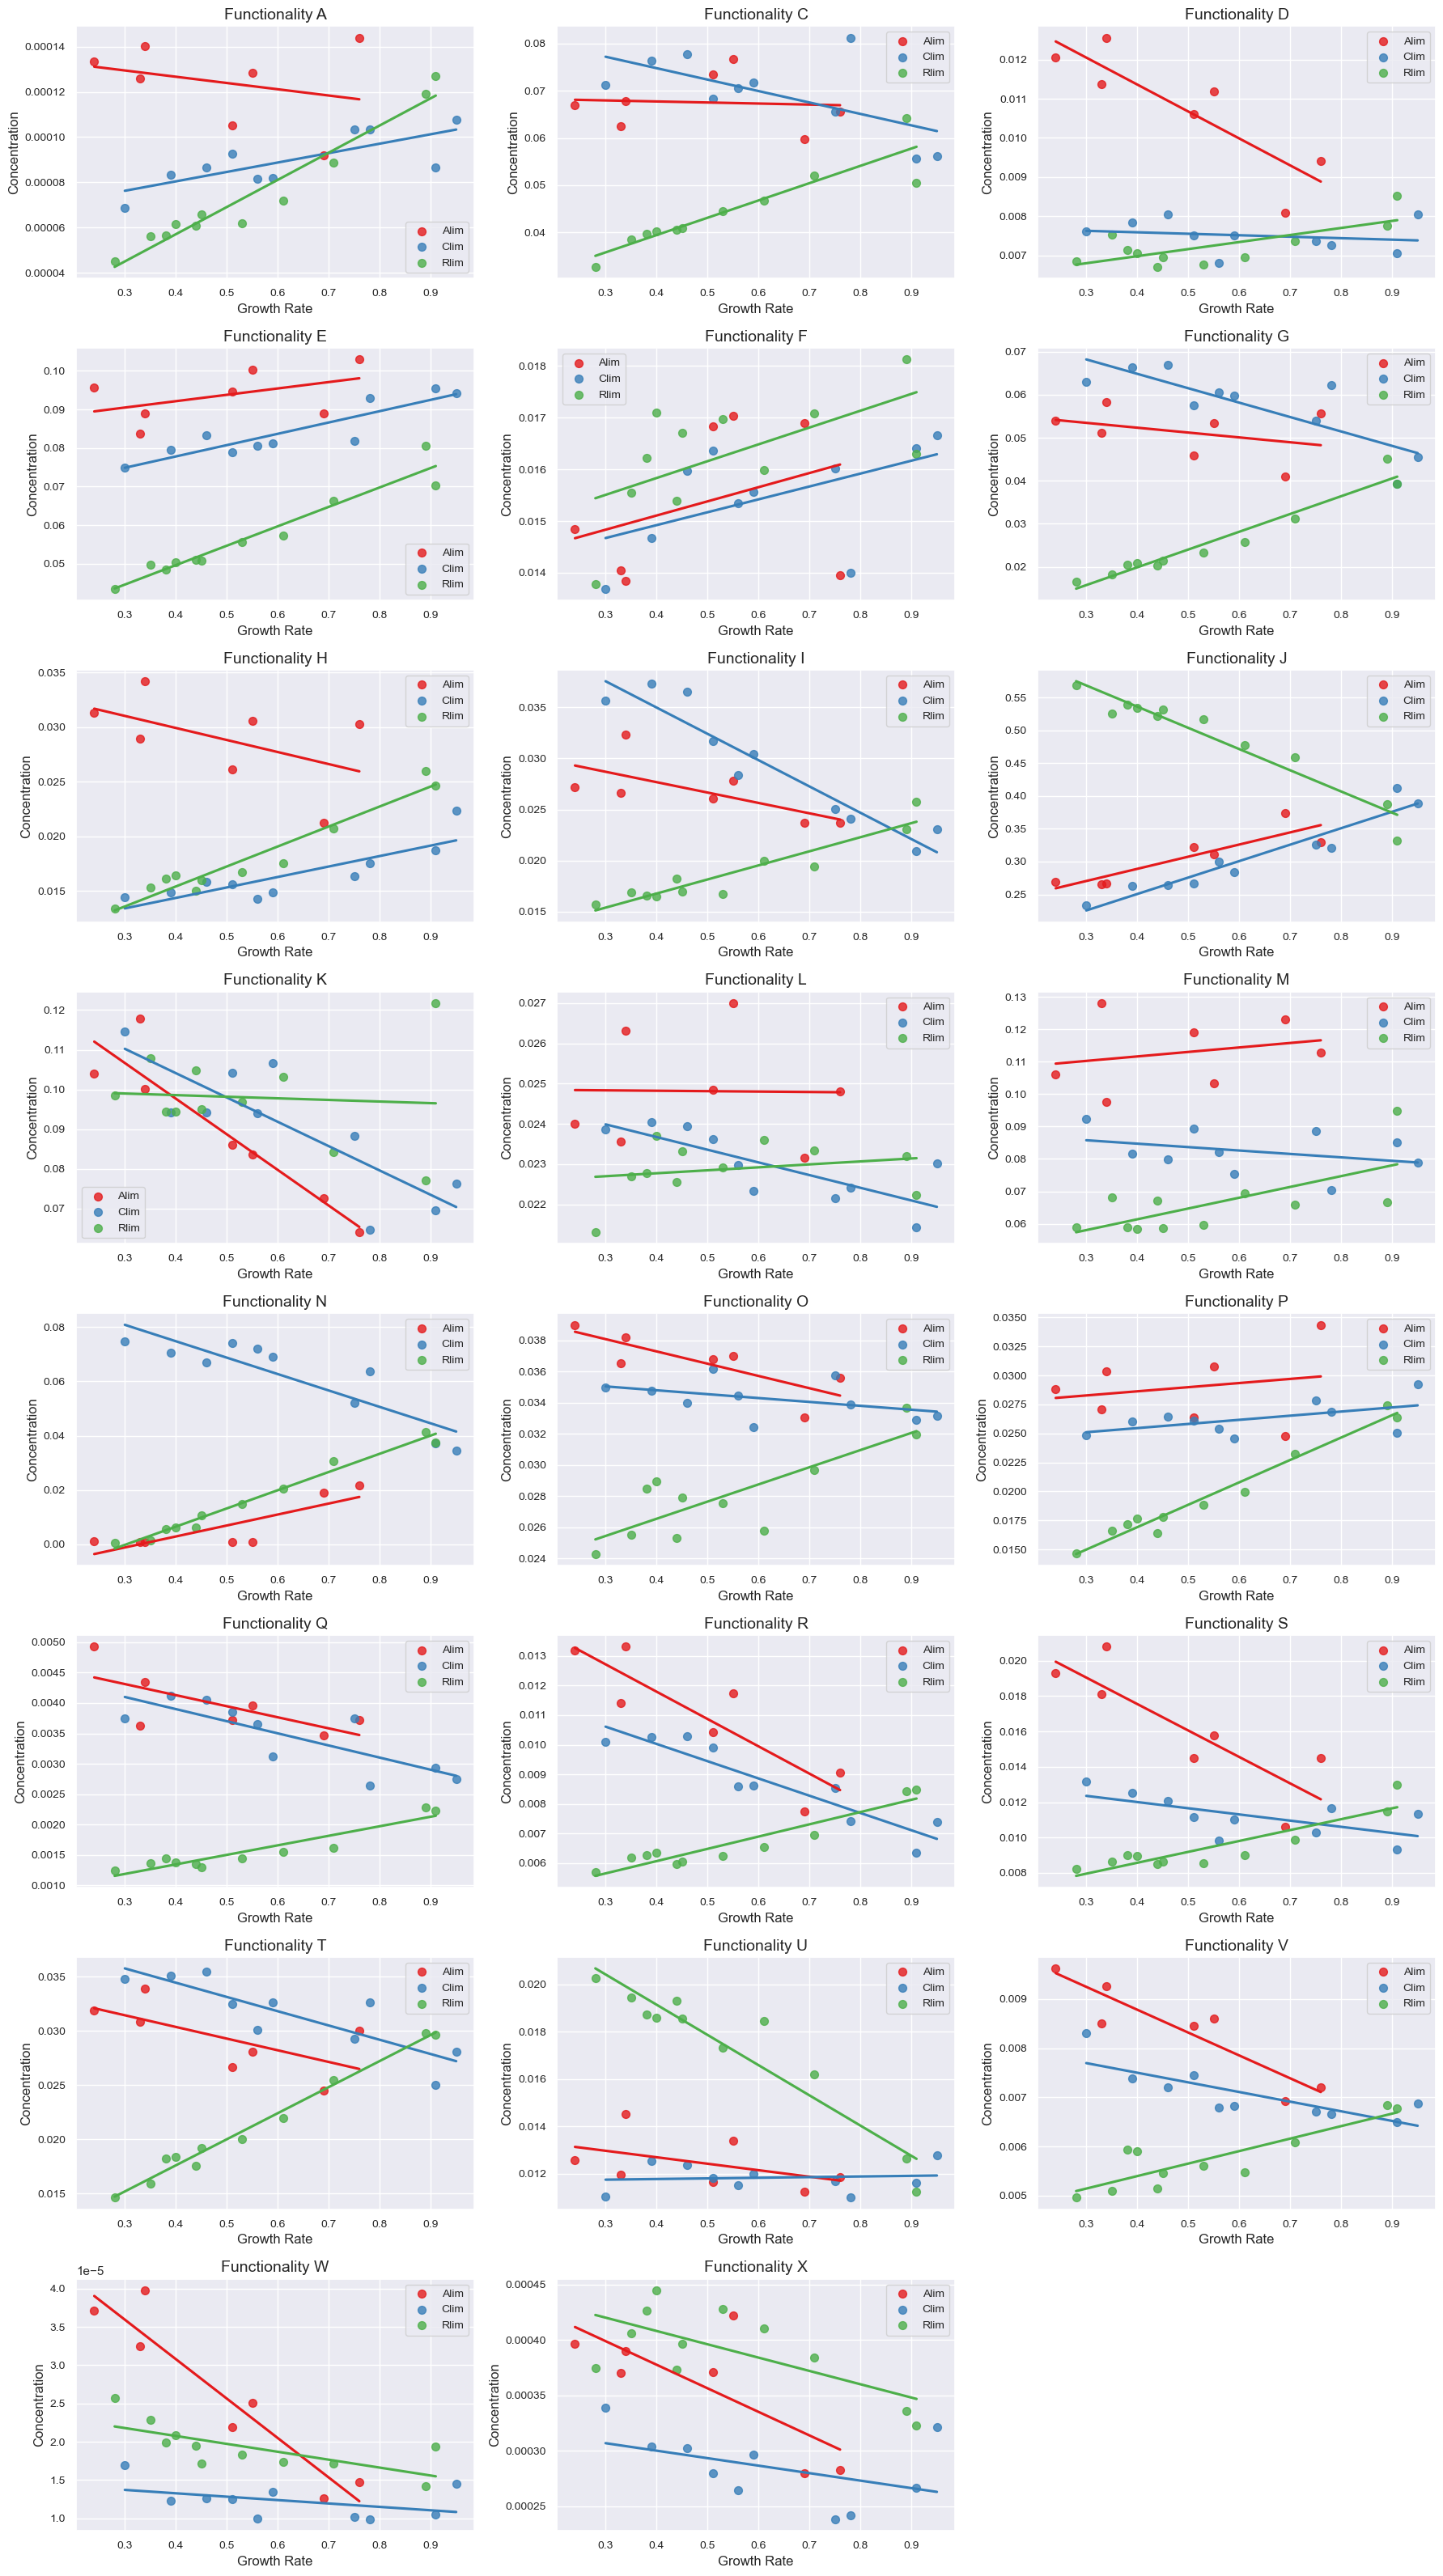

In [15]:
plot_join_sep_by_func()

### Analyze the different experimental conditions
In the main equations the parameters depending on $E$ could, in principle, all vary simultaneously. Experimental conditions instead are such that only one of the rates $\kappa_A$, $\kappa_C$, $\kappa_t$ changes and the other two are fixed. Therefore we analyze separetely the three experimental setting. For each we plot the fraction of proteome relative to each functionality with respect to the growth rate.

## A-lim

In this experimental condition $\kappa_A$ is changed by varying the supplement provided to E. Coli, while $\kappa_t$ and $\kappa_C$ remains constant. Therefore:
$$ \phi_A = \phi_{max} - \phi_0 -\lambda \left(\frac{1}{\kappa_t}+\frac{1}{\kappa_C} \right) $$
$$ \phi_C = \frac{\lambda}{\kappa_C} $$
$$ \phi_R = \phi_0 + \frac{\lambda}{\kappa_t} $$
$$ \phi_Q = \text{const}$$

## C-lim

In this experimental condition $\kappa_C$ is changed, either by changing the supplement or the strain of E. Coli, while $\kappa_t$ and $\kappa_A$ remains constant. Therefore in our model:
$$ \phi_A = \frac{\lambda}{\kappa_A} $$
$$ \phi_C = \phi_{max} - \phi_0 -\lambda \left(\frac{1}{\kappa_t}+\frac{1}{\kappa_A} \right)$$
$$ \phi_R = \phi_0 + \frac{\lambda}{\kappa_t} $$
$$ \phi_Q = \text{const}$$

## R-lim

In this experimental condition $\kappa_t$ is changed by varying the amount of antibiotics provided to the culture, while $\kappa_C$ and $\kappa_A$ remains constant. Therefore:
$$ \phi_A = \frac{\lambda}{\kappa_A} $$
$$ \phi_C = \frac{\lambda}{\kappa_C} $$
$$ \phi_R = \phi_{max} - \lambda \left(\frac{1}{\kappa_A}+\frac{1}{\kappa_C} \right) $$
$$ \phi_Q = \text{const}$$

### Discussion

Theoretical we expect the following behaviour for the slope $m$ of the fractions $\phi_R$, $\phi_C$, $\phi_A$, $\phi_Q$ in the experimental conditions C-lim, A_lim, R-lim:
$$
\begin{array}{|c|c|c|c|}
\hline
 & C\text{-}lim & A\text{-}lim & R\text{-}lim \\
\hline
m>0 & R,A & R, C &  A,C\\
\hline
m=0 & Q & Q & Q \\
\hline
m<0 & C & A & R \\
\hline
\end{array}
$$

Of course in real data we need to choose a threshold $m_t$ above which we consider the slope to be significantly different from 0. This value seems, for the moment, completely arbitrary but looking at the presented plot $m_t = ...$ seems a reasonable choice. \\
We find therefore:

In [66]:
data1 = {'Alim': [None , None, None],
        "Clim": [None ,None , None],
        'Rlim': [None, None, None]}

treshold_max = 0.001
treshold_min = -0.0005

In [67]:
Rlim_dic = list(RTcog_func_by_functionality.keys())

mayores= ''
menores= ''
iguales= ''
for key in Rlim_dic:
    data = RTcog_func_by_functionality[key]

    slope = (np.polyfit(data['Growth.rate..1.h.'], data['Gene.sum'], 1)[0])
    #print(key, slope)

    if slope > treshold_max:
        mayores = mayores + key[-1]
        data1['Rlim'][0] = mayores
    elif slope < treshold_min:
        menores  = menores + key[-1]
        data1['Rlim'][2] = menores
    else :
        iguales = iguales + key[-1]
        data1['Rlim'][1] = iguales

In [68]:
Clim_dic = list(CTcog_func_by_functionality.keys())

mayores= ''
menores= ''
iguales= ''
for key in Clim_dic:
    data = CTcog_func_by_functionality[key]

    slope = (np.polyfit(data['Growth.rate..1.h.'], data['Gene.sum'], 1)[0])
    #print(key, slope)

    if slope > treshold_max:
        mayores = mayores + key[-1]
        data1['Clim'][0] = mayores
    elif slope < treshold_min:
        menores  = menores + key[-1]
        data1['Clim'][2] = menores
    else :
        iguales = iguales + key[-1]
        data1['Clim'][1] = iguales

In [69]:
Alim_dic = list(ATcog_func_by_functionality.keys())
mayores= ''
menores= ''
iguales= ''

for key in Alim_dic:
    data = ATcog_func_by_functionality[key]

    slope = (np.polyfit(data['Growth.rate..1.h.'], data['Gene.sum'], 1)[0])
    #print(key, slope)

    if slope > treshold_max:
        mayores = mayores + key[-1]
        data1['Alim'][0] = mayores
    elif slope < treshold_min:
        menores  = menores + key[-1]
        data1['Alim'][2] = menores
    else :
        iguales = iguales + key[-1]
        data1['Alim'][1] = iguales

In [70]:
cat_list = []
anal_list = []
ribo_list = []
q_list= [ ]
both_list = []

In [71]:
Rlim_dic = list(RTcog_func_by_functionality.keys())
for funcional in Rlim_dic:
  fun = funcional[-1]
  # q clasify
  if fun in data1["Alim"][1] and fun in data1['Clim'][1] and fun in data1['Rlim'][1]:
    q_list.append(fun)
  # rlim clasify
  elif fun in data1["Alim"][0] and fun in data1['Clim'][0] and fun in data1['Rlim'][2]:
    ribo_list.append(fun)
    # anal clasify
  elif fun in data1["Alim"][2] and fun in data1['Clim'][0] and fun in data1['Rlim'][0]:
    anal_list.append(fun)
    #cat clasify
  elif fun in data1["Alim"][0] and fun in data1['Clim'][2] and fun in data1['Rlim'][0]:
    cat_list.append(fun)
  else:
    both_list.append(fun)

Invariant fraction:  ['A', 'W', 'X']
Ribosome fraction:  ['J']
Anabolic fraction:  ['H']
Catabolic fraction:  ['M', 'N']
Multiples fraction:  ['C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']


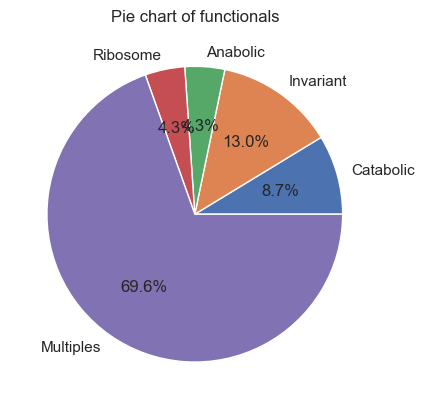

In [72]:
print('Invariant fraction: ',q_list)
print('Ribosome fraction: ',ribo_list)
print('Anabolic fraction: ',anal_list)
print('Catabolic fraction: ',cat_list)
print('Multiples fraction: ',both_list)

data_dict = {
    "cat_list": cat_list,
    "q_list": q_list,
    "anal_list": anal_list,
    "ribo_list": ribo_list,
    "both_list": both_list
}

df = pd.DataFrame({ col: pd.Series(vals) for col, vals in data_dict.items() })

list_counts = {
    'Catabolic':  len(cat_list),
    'Invariant':    len(q_list),
    'Anabolic': len(anal_list),
    'Ribosome': len(ribo_list),
    'Multiples': len(both_list)
}

df_counts = pd.DataFrame.from_dict(list_counts, 
                                   orient='index', 
                                   columns=['Count'])
ax = df_counts.plot(
    kind='pie',      
    y='Count',        
    autopct='%1.1f%%', 
    legend=False,
    ylabel=''          
)
ax.set_title('Pie chart of functionals')
plt.show()

By comparing the predictions with the results we can clearly identify $J$ as the only functional category that is consistent with the class $R$ in all the three experimental settings. Indeed, $J$ is described as related to  "Translation, ribosomal structure and biogenesis" so our conclusions seems reasonable.
Then we see that functionalities $?$ and $?$ are the only one consistent with, respectively, classes C and A so we conclude that they must be catabolic and anabolic proteins. Indeed, they are described as "..." and "...", again confirming the
Additionally, the abundance of some functionalities is found to be indipendent of the growth rate in all experimental settings, so we classify them as belonging to class Q.
There are some problems with this classification: for example, functionality $?$ acts as a catabolic group in C-lim(A-lim) and as an anabolic group in A-lim(C-lim), a behavior that the model is not able to account for but is biologically possible when proteins interact differently in presence of different substrates, which is the case switching from C-lim, to A-lim, to R-lim.
The same is true for functional group that behave as catabolic in ... and do not depend on Q in ... .

### Possible extension to our analysis

We have based our classification entirely on the slope $m$ of the relations $\phi_{\alpha} \propto \lambda $ but we could extend it to the intercept $q$ of the same linear relations, with the following expected dependencies:

$$
\begin{array}{|c|c|c|c|}
\hline
 & C\text{-}lim & A\text{-}lim & R\text{-}lim \\
\hline
q>0 & C,R,Q & A,R,Q &  R,Q \\
\hline
q=0 & A & C & A,C \\
\hline
\end{array}
$$
The idea would be to see if the two classifications are consistent.
\\
The data would then make it possibile to estimate some constant parameters of the cell such as $\phi_{max}$ and $\phi_0$. What about the k? could we este